# Dataset

In [ ]:
!cp -r '/content/drive/MyDrive/Data/Data_set/' '/content'

# Imports

In [ ]:
%cd '/content/drive/MyDrive/Final_Project'
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchsummary import summary
import torchvision.models as models
import torch.nn as nn
import torch

from Dataloder import Cityscapes
from SegNet import *
from UNET import *
from deeplabv3 import custom_DeepLabv3_101, custom_DeepLabv3_50

/content/drive/MyDrive/Final_Project


# Intitial Config

In [ ]:
NUM_CLASSES = 20
BATCH_SIZE = 2
IMAGE_SIZE = 650
NUM_EPOCHS = 1
SEED = 101

torch.manual_seed(SEED) 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# DataLoader

In [ ]:
train_dataset = Cityscapes(root= '/content/Data_set',phase= 'train' , IMG_SIZE = IMAGE_SIZE, num_classes = NUM_CLASSES)
val_dataset   = Cityscapes(root= '/content/Data_set',phase= 'val'   , IMG_SIZE = IMAGE_SIZE, num_classes = NUM_CLASSES)

Total Number of Images: 2975
Total Number of Masks: 2975
Total Number of Images: 500
Total Number of Masks: 500


In [ ]:
from torch.utils.data import Dataset, DataLoader
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last = True)
val_data_loader   = DataLoader(val_dataset  , batch_size=BATCH_SIZE, drop_last = True)

In [ ]:
X, Y = next(iter(val_data_loader))
print('X shape:', X.shape, X.dtype)
print('Y shape:', Y.shape, Y.dtype)
X, Y = X.to(device), Y.to(device)

X shape: torch.Size([2, 3, 650, 650]) torch.float32
Y shape: torch.Size([2, 20, 650, 650]) torch.int64


# Checking Data

In [ ]:
label = torch.argmax(Y, dim=1)

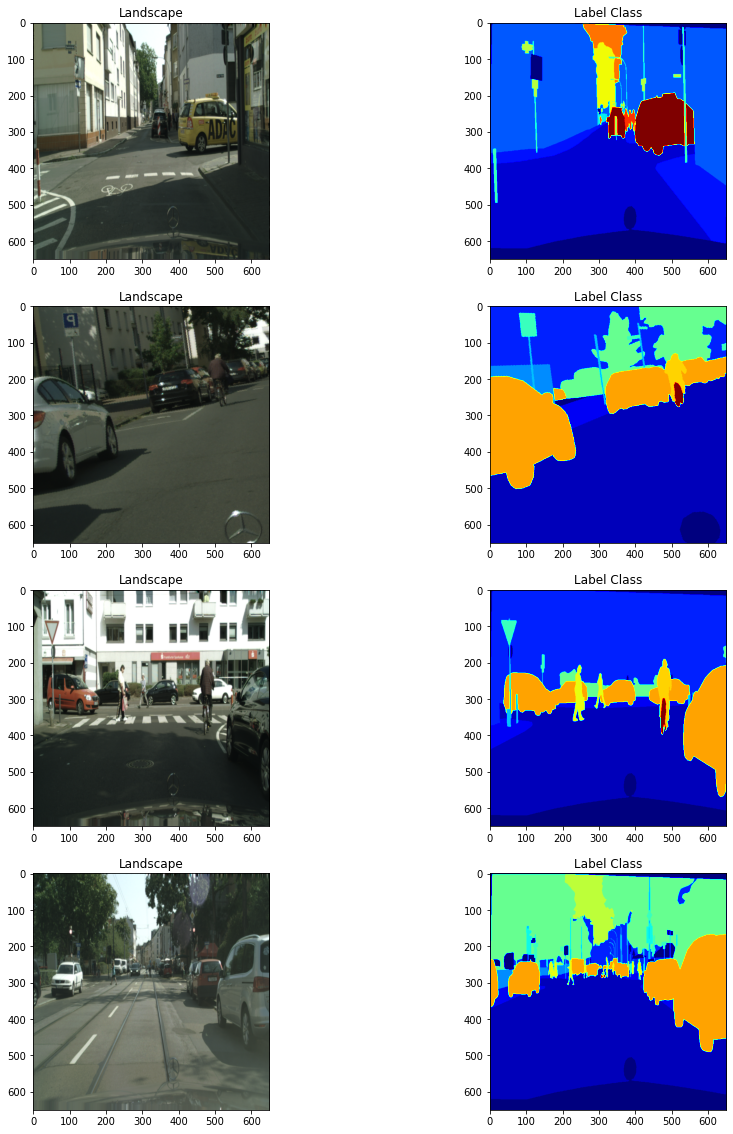

In [ ]:
fig, axes = plt.subplots(BATCH_SIZE, 2, figsize=(3*5, BATCH_SIZE*5))

for i in range(BATCH_SIZE):
    
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = label[i].cpu().detach().numpy()

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, cmap = 'jet')
    axes[i, 1].set_title("Label Class")

## Checking each channel of a label


[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0 1]
[0 1]
[0]
[0 1]
[0 1]
[0]
[0 1]
[0 1]
[0]
[0 1]
[0]
[0]
[0]
[0]
[0]


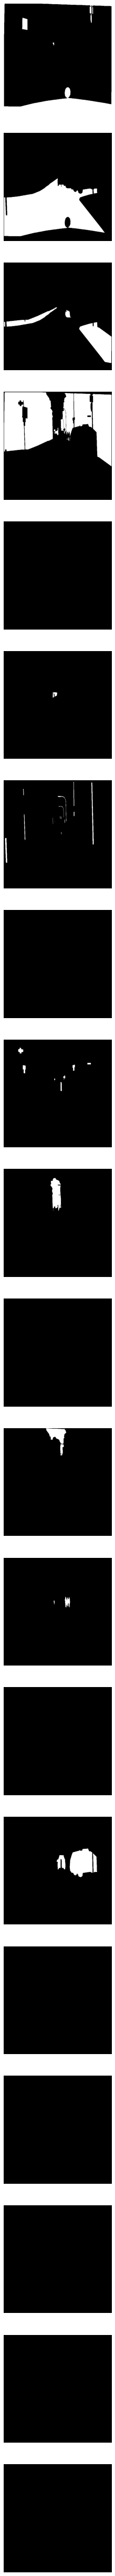

In [ ]:
label = Y[0].cpu().detach().numpy()

fig, axes = plt.subplots(ncols = 1, nrows= NUM_CLASSES, figsize=(50,90))
for i in range(NUM_CLASSES):
  print(np.unique(label[i]))
  axes[i].imshow(label[i], cmap = 'gray')
  axes[i].axis('off')

# Model

In [ ]:
# UNet(out_channels=NUM_CLASSES)
model = custom_DeepLabv3_101(out_channel=NUM_CLASSES)
model.to(device)

## model's parameters

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("total model's parameters     : " , pytorch_total_params/1000000, 'M')
print("trainable model's parameters : " , trainable_params/1000000, 'M')

total model's parameters     :  60.995945 M
trainable model's parameters :  60.995945 M


## prediction using pretrained weights 

In [ ]:
X, Y = X.to(device).float(), Y.to(device).long()
Y_pred = model(X)

In [ ]:
Y_pred['out'].shape

torch.Size([4, 20, 512, 512])

In [ ]:
Y = torch.argmax(Y, dim=1)

In [ ]:
Y_pred = torch.argmax(Y_pred['out'], dim=1).float()

In [ ]:
print(X.shape)
print(Y.shape)
print(Y_pred.shape)

torch.Size([4, 3, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])


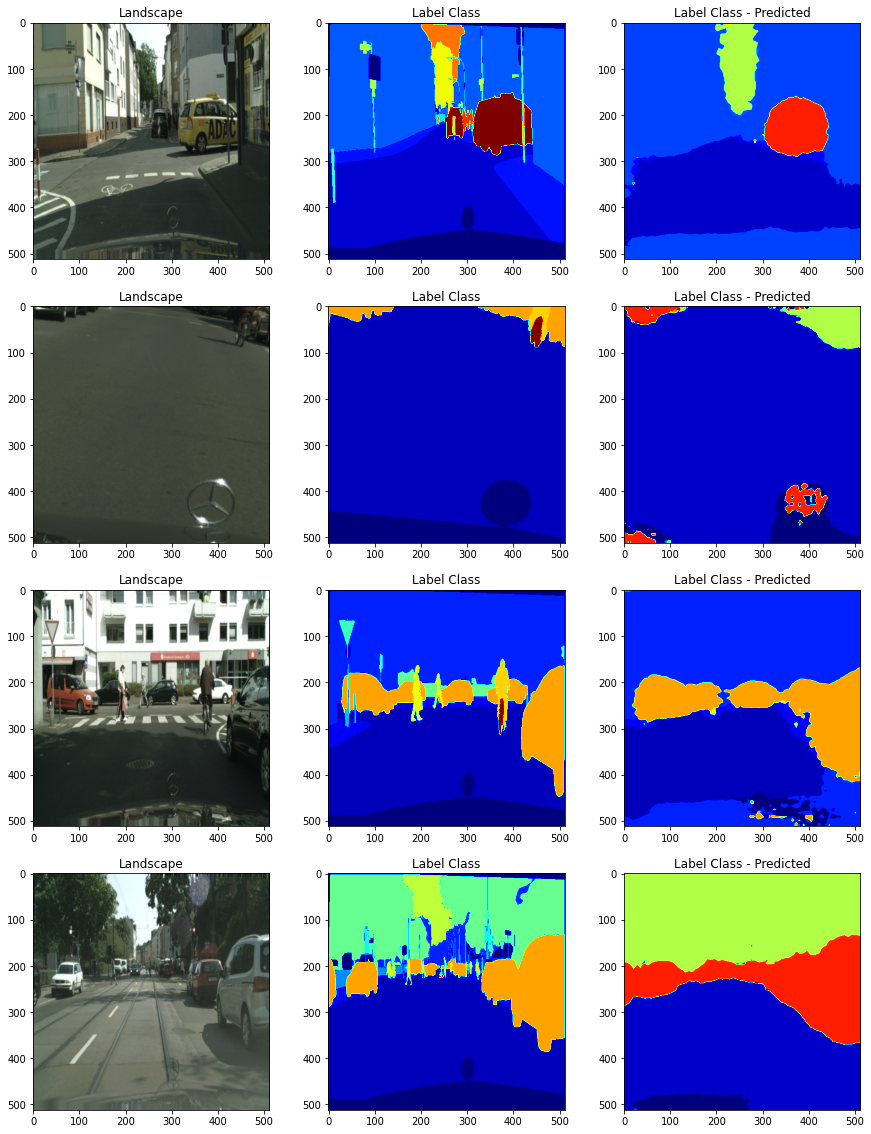

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(3*5, 4*5))

for i in range(4):
    
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()


    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
   
    axes[i, 1].imshow(label_class, cmap = 'jet')
    axes[i, 1].set_title("Label Class")
   
    axes[i, 2].imshow(label_class_predicted, cmap = 'jet')
    axes[i, 2].set_title("Label Class - Predicted")

# Defining metrics

In [ ]:
def MeanIoU(num_classes, target, pred):
  mIoU = 0

  for i in range(num_classes):
    
    intersection = torch.logical_and(target[i].int(), pred[i].int())
    union = torch.logical_or(target[i].int(), pred[i].int())
    iou_score = torch.sum(intersection) / torch.sum(union)
    
    if (torch.sum(union) == 0):
      iou_score = 1
    
    mIoU = mIoU + iou_score
  
  return mIoU / num_classes

In [ ]:
def label_categorization(img, H, W):
  channled_mask = torch.zeros((NUM_CLASSES, H, W)) 
  for i in range(NUM_CLASSES):
    # Converting [1, IMAGE_SIZE, IMAGE_SIZE] to [num_classes, 1024, 2048]
    channled_mask[i][img.squeeze() == i] = 1     
  return channled_mask

In [ ]:
def binary_mask(self, img):
  for i in range(self.num_classes):
    img[i] = (img[i] > 0.50).float() 
  return img

## Checking Metrics Credibility

In [ ]:
X, Y = next(iter(val_data_loader))
X, Y = X.to(device).float(), Y.to(device).long()
Y_pred = model(X)

In [ ]:
MeanIoU(num_classes = NUM_CLASSES, target = Y[0], pred= Y[0])

tensor(1., device='cuda:0')

# Loading model and testing Loaded model

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Final_Project/models/deeplab50_1_epoch.pt'))
model.load_state_dict(torch.load('/content/drive/MyDrive/Final_Project/models/deeplab101_1_epoch.pt'))

# model.eval()

<All keys matched successfully>

In [ ]:
# from PIL import Image
# import numpy as np
# from torchvision import transforms
# from glob import glob

# image_path = glob("/content/Data_set/train_images/*/*.png")
# masks_path = glob("/content/Data_set/train_masks/*/*.png")

# input_transform = transforms.Compose([
#           transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#           transforms.ToTensor(),
#             ])
            
# target_transform = transforms.Compose([
#       transforms.Grayscale(),
#       transforms.PILToTensor(),
#       transforms.Lambda(label_categorization(H = 1024, W=2048)),
#       transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#       transforms.Lambda(binary_mask),
#       # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#     ])


# im1 = Image.open(image_path[0])
# im2 = Image.open(masks_path[0])



# Image.fromarray(np.hstack((np.array(im1),np.array(im2)))).show()

In [ ]:
X, Y = X.to(device).float(), Y.to(device).long()
Y_pred = model(X)

In [ ]:
Y_pred['out'].shape

torch.Size([2, 20, 650, 650])

In [ ]:
Y = torch.argmax(Y, dim=1)

In [ ]:
Y_pred = torch.argmax(Y_pred['out'], dim=1).float()

In [ ]:
print(X.shape)
print(Y.shape)
print(Y_pred.shape)

torch.Size([2, 3, 650, 650])
torch.Size([2, 650, 650])
torch.Size([2, 650, 650])


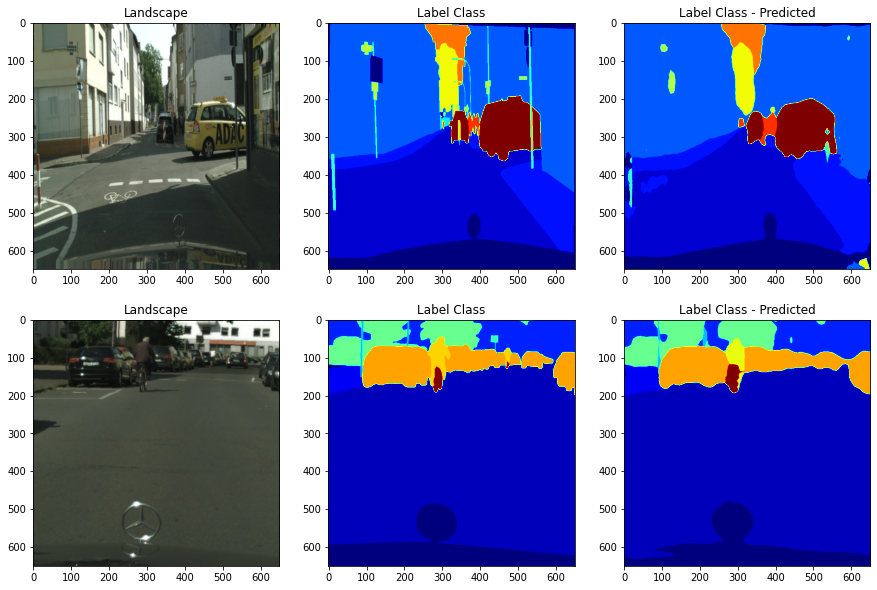

In [ ]:
fig, axes = plt.subplots(BATCH_SIZE, 3, figsize=(3*5, BATCH_SIZE*5))

for i in range(BATCH_SIZE):
    
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()


    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
   
    axes[i, 1].imshow(label_class, cmap = 'jet')
    axes[i, 1].set_title("Label Class")
   
    axes[i, 2].imshow(label_class_predicted, cmap = 'jet')
    axes[i, 2].set_title("Label Class - Predicted")

# Training

In [ ]:
import time
from time import sleep
import copy
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
dataloaders = {'train': train_data_loader ,
               'val': val_data_loader}

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 200, verbose = False)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_IoU_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_IoU = 0.0
    mIoU = 0.0
    loss = 0.0
    batch_mIoU = 0
    IoU_changes = []
    train_losses = []
    val_losses   = []
    for epoch in range(num_epochs):
        tic = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('--' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            t = tqdm(dataloaders[phase])
            for batch_idx, (inputs, labels) in enumerate(t):
                # sleep(0.1)
                batch_mIoU = 0
                t.set_description(f"best IoU : {best_IoU:.2f}, Mean IoU : {mIoU:.2f}, loss : {loss:.2f}")
                t.refresh()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], labels.float())
                    # print(mIoU)  
                    y      = torch.argmax(labels, dim=1)
                    y_pred = torch.argmax(outputs['out'], dim=1)

                    for i in range(BATCH_SIZE):
                      batch_mIoU += MeanIoU(num_classes = NUM_CLASSES,
                                      target = label_categorization(y[i]),
                                      pred   = label_categorization(y_pred[i])
                                      )
                    mIoU = batch_mIoU / (BATCH_SIZE)
                    IoU_changes.append(mIoU)
                    # preds = torch.argmax(outputs['out'], dim=1).detach().cpu().numpy()
                    # gt = torch.argmax(labels, dim=1).detach().cpu().numpy()
                    # conf_mat = confusion_matrix(y_pred=preds.flatten(), y_true=gt.flatten(), labels=list(range(NUM_CLASSES)))
                    # mIoU = Metrics(conf_mat)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        train_losses.append(loss)
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                    if (phase == 'val') :
                        val_losses.append(loss) 

            # epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            toc = time.time()
            
            print(f'IoU: {mIoU:.2f}, {phase} Loss: {loss:.2f}, Time: {((toc - tic) / 60):.2f} min ')
            # deep copy the model
            if phase == 'val' and mIoU > best_IoU:
                best_IoU = mIoU
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_IoU_history.append(mIoU)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val IoU: {:4f}'.format(best_IoU))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_IoU_history, train_losses, val_losses, IoU_changes

In [ ]:
torch.cuda.empty_cache()
model_ft, hist, train_losses, val_losses, IoU_changes = train_model(model , dataloaders , criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 0/0
--------------------


  0%|          | 0/1487 [00:00<?, ?it/s]

IoU: 0.55, train Loss: 0.56, Time: 77.34 min 


  0%|          | 0/250 [00:00<?, ?it/s]

IoU: 0.66, val Loss: 0.39, Time: 85.70 min 

Training complete in 85m 42s
Best val IoU: 0.664605


In [ ]:
val_losses

In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/Final_Project/models/deeplab101_1_epoch.pt')

# After training

In [ ]:
X, Y = next(iter(val_data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_ft(X)
# Y_pred = model(X)
print(Y_pred['out'].shape)

torch.Size([2, 20, 650, 650])


In [ ]:
y_pred = torch.argmax(Y_pred['out'], dim=1)
print(y_pred[0].shape)

torch.Size([650, 650])


In [ ]:
y = torch.argmax(Y, dim=1)
print(y[0].shape)

torch.Size([650, 650])


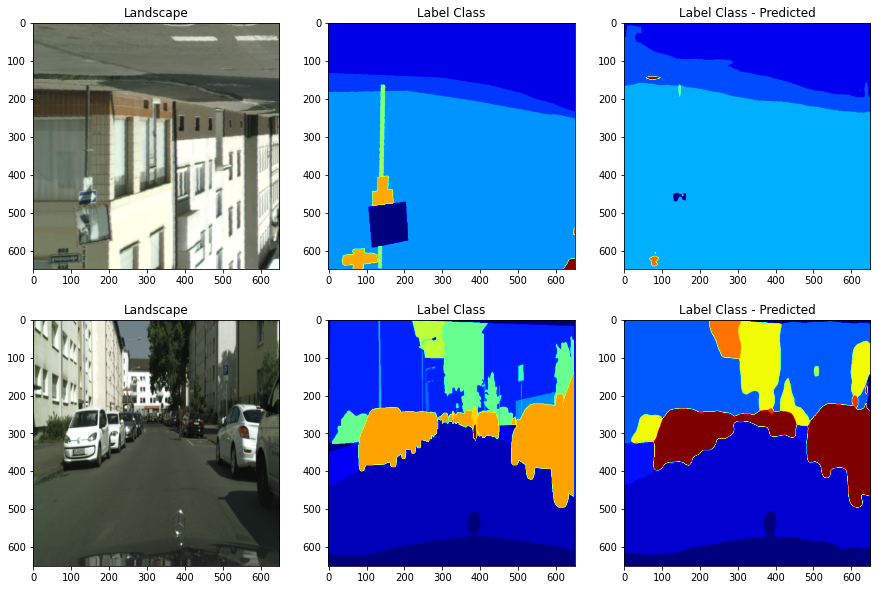

In [ ]:
fig, axes = plt.subplots(BATCH_SIZE, 3, figsize=(3*5, BATCH_SIZE*5))

for i in range(BATCH_SIZE):
    
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = y[i].cpu().detach().numpy()
    label_class_predicted = y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, cmap = 'jet')
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted, cmap = 'jet')
    axes[i, 2].set_title("Label Class - Predicted")

In [ ]:
mIoU = 0
for i in range(BATCH_SIZE):
  mIoU = MeanIoU(num_classes = NUM_CLASSES,
                  target = label_categorization(y[i]),
                  pred   = label_categorization(y_pred[i])
                  )
  print(mIoU)
mIoU = mIoU / BATCH_SIZE

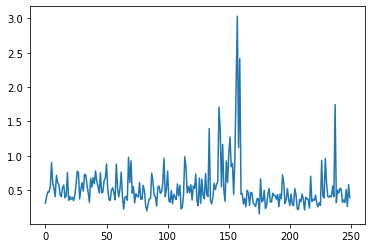

In [ ]:
val_loss = [i.cpu().detach().numpy() for i in val_losses]
plt.plot(val_loss)

In [ ]:
train_losses[0].item()

3.2509193420410156

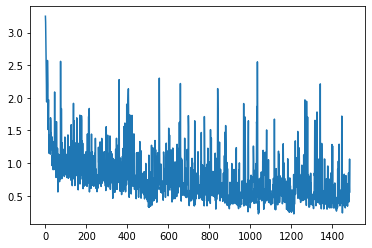

In [ ]:
train_loss = [i.item() for i in train_losses]
plt.plot(train_loss)

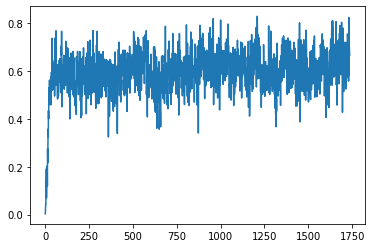

In [ ]:
IoUs = [i.cpu().detach().numpy() for i in IoU_changes]
plt.plot(IoUs[])

In [ ]:
def MeanIoU(num_classes, target, pred):
  mIoU = 0

  for i in range(num_classes):
    
    intersection = torch.logical_and(target[i].int(), pred[i].int())
    union = torch.logical_or(target[i].int(), pred[i].int())
    iou_score = torch.sum(intersection) / torch.sum(union)
    
    if (torch.sum(union) == 0):
      iou_score = 1
    
    print(f"channel {i}: {iou_score}")

    mIoU = mIoU + iou_score

  return mIoU / num_classes

In [ ]:
  mIoU = MeanIoU(num_classes = NUM_CLASSES,
                  target = label_categorization(y[1]),
                  pred   = label_categorization(y_pred[1])
                  )

channel 0: 0.8387318253517151
channel 1: 0.9713154435157776
channel 2: 0.8195666074752808
channel 3: 0.8868963122367859
channel 4: 1
channel 5: 0.0
channel 6: 0.0
channel 7: 1
channel 8: 0.39118826389312744
channel 9: 0.8718063831329346
channel 10: 0.0
channel 11: 0.8791792392730713
channel 12: 0.0
channel 13: 0.0
channel 14: 0.8874558806419373
channel 15: 1
channel 16: 1
channel 17: 1
channel 18: 1
channel 19: 0.0


pred values :  tensor([0., 1.])
label values :  tensor([0., 1.])
pred values :  tensor([0., 1.])
label values :  tensor([0., 1.])
pred values :  tensor([0., 1.])
label values :  tensor([0., 1.])
pred values :  tensor([0., 1.])
label values :  tensor([0., 1.])
pred values :  tensor([0.])
label values :  tensor([0.])
pred values :  tensor([0., 1.])
label values :  tensor([0.])
pred values :  tensor([0., 1.])
label values :  tensor([0.])
pred values :  tensor([0.])
label values :  tensor([0.])
pred values :  tensor([0., 1.])
label values :  tensor([0., 1.])
pred values :  tensor([0., 1.])
label values :  tensor([0., 1.])
pred values :  tensor([0.])
label values :  tensor([0., 1.])
pred values :  tensor([0., 1.])
label values :  tensor([0., 1.])
pred values :  tensor([0.])
label values :  tensor([0., 1.])
pred values :  tensor([0., 1.])
label values :  tensor([0.])
pred values :  tensor([0., 1.])
label values :  tensor([0., 1.])
pred values :  tensor([0.])
label values :  tensor([0.])
pred

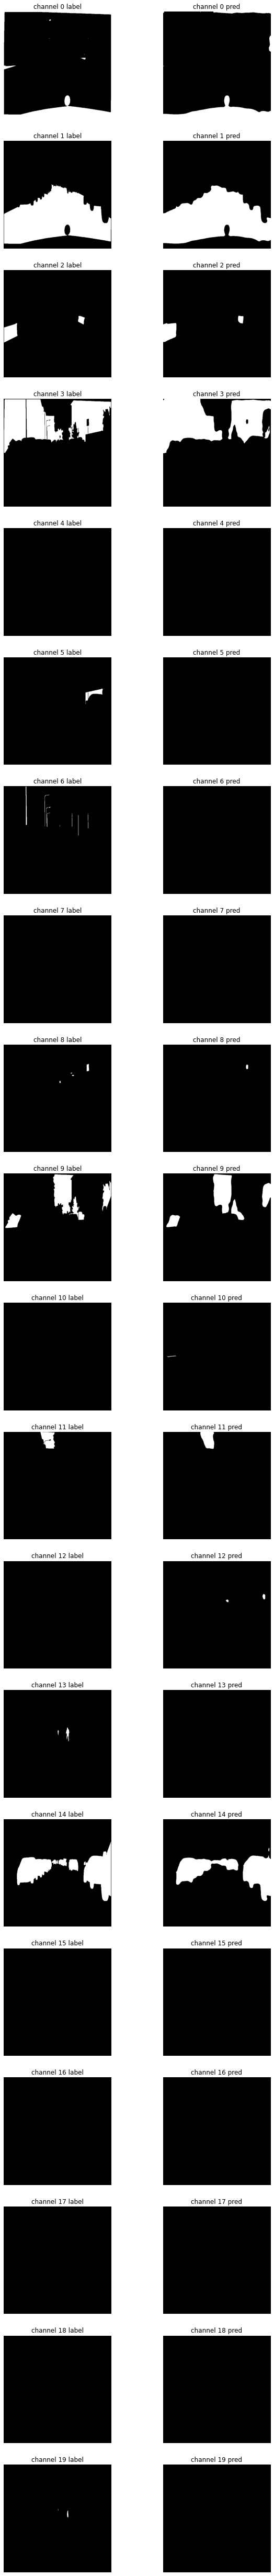

In [ ]:
# label = Y_pred['out'][0].cpu().detach().numpy()

img_num = 1

fig, axes = plt.subplots(ncols = 2, nrows= NUM_CLASSES, figsize=(10,90))
for i in range(NUM_CLASSES):
  print('pred values : ',torch.unique(label_categorization(y[img_num])[i]))
  axes[i][0].imshow( label_categorization(y[img_num])[i].cpu().detach().numpy() , cmap = 'gray')
  axes[i][0].set_title(f'channel {i} label')
  axes[i][0].axis('off')

  print('label values : ',torch.unique(label_categorization(y_pred[img_num])[i]))
  axes[i][1].imshow(label_categorization(y_pred[img_num])[i].cpu().detach().numpy(), cmap = 'gray')
  axes[i][1].set_title(f'channel {i} pred')
  axes[i][1].axis('off')

In [ ]:
mIoU = MeanIoU(num_classes = NUM_CLASSES,
                target = label_categorization(y[img_num]),
                pred   = label_categorization(y_pred[img_num])
                )

channel 0: 0.9190475344657898
channel 1: 0.9684163928031921
channel 2: 1
channel 3: 0.805023729801178
channel 4: 1
channel 5: 1
channel 6: 0.0
channel 7: 1
channel 8: 0.0
channel 9: 0.7586206793785095
channel 10: 1
channel 11: 1
channel 12: 1
channel 13: 0.0
channel 14: 0.9411194920539856
channel 15: 1
channel 16: 1
channel 17: 1
channel 18: 1
channel 19: 0.0
